# 5 - 序列到序列卷积学习

在这个笔记本中，我们将实现[卷积序列到序列学习](https://arxiv.org/abs/1705.03122)模型。

注意！本笔记本需要 mindspore 高于  2.2.10 版本运行。低版本存在view机制错误导致梯度丢失，训练过程中梯度丢失导致loss不变。

![](assets/convseq2seq0.png)

## 简介

这个模型与这些教程中先前使用的模型截然不同。它根本没有使用循环组件。相反，它使用卷积层，通常用于图像处理。有关在文本情感分析中使用卷积层的介绍，请参见[此](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb)教程。

简而言之，卷积层使用*过滤器*。这些过滤器具有*宽度*（在图像中还有*高度*，但通常不适用于文本）。如果一个过滤器的宽度为3，那么它可以查看3个连续的标记。每个卷积层有许多这些过滤器（在本教程中为1024）。每个过滤器将沿着序列滑动，从开始到结束，一次查看3个连续的标记。这些1024个过滤器中的每一个都将学会从文本中提取不同的特征。这个特征提取的结果将由模型使用 - 可能作为输入到另一个卷积层。然后，所有这些都可以用于从源句中提取特征，以将其翻译成目标语言。

## 准备数据

首先，让我们导入所有必需的模块并设置用于可重复性的随机种子。


In [63]:
import mindspore as ms
import mindspore.context as context
import mindspore.nn as nn
import mindspore.ops as ops
from functools import partial

import random
import time
import numpy as np
import spacy
import datasets
from tqdm.notebook import tqdm
import evaluate as evaluate_hf
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [2]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
ms.set_seed(seed)

导入数据集，不再赘述

In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")
train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")
def tokenize_example(
    example,
    en_nlp,
    de_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}


max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "de_nlp": de_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}


train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Found cached dataset json (/root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-39e2a81dd5826464.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-340eed13fdfe768e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-05a87c7dda3754fe.arrow


In [4]:
import collections
class Vocab:
    """一个词汇表的实现"""
    def __init__(self, tokens:list, min_freq=0, reserved_tokens:list=None) -> None:
        self.default_index = None
        if tokens is not None:
            # 当第一个条件满足时，就不会跳到第二个判断，避免了空列表报错的情况。
            if len(tokens)!=0 and isinstance(tokens[0], list):
                tokens = [i for line in tokens for i in line]
        else:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter=collections.Counter(tokens)
        # 按出现词频从高到低排序
        self._token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        # 通过列表,利用序号访问词元。
        self.idx_to_token = [] + reserved_tokens # 未知词元<unk>的索引为0, 保留词元排在最前
        self.token_to_idx = {
            i: k
            for k, i in enumerate(self.idx_to_token) 
        }
        
        for token, freq in self._token_freqs:
            if freq < min_freq:  # 过滤掉出现频率低于要求的词
                break
            if token not in self.token_to_idx:  
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, input_tokens):
        """输入单字串或序列, 将其全部转化为序号编码"""
        if isinstance(input_tokens, str):
            out =  self.token_to_idx.get(input_tokens, self.default_index)
            if out is None:
                raise Exception('Please call "set_default_index" before getting unknown index')
            return out
        return [self.__getitem__(token) for token in input_tokens]
    
    def __repr__(self) -> str:
        show_items = 5 if len(self) > 5 else len(self)
        out = f"<Vocab with {len(self)} tokens: "
        for i in range(show_items):
            out += f'"{self.idx_to_token[i]}", '
        out += "...>"
        return out

    def __contains__(self, token:str) -> bool:
        return token in self.idx_to_token

    def to_tokens(self, input_keys):
        """输入单s索引或序列, 将其全部转化为词元"""
        if isinstance(input_keys, int):
            return self.idx_to_token[input_keys] if input_keys < len(self) else self.idx_to_token[0]
        elif isinstance(input_keys, (list, tuple)):
            return [self.to_tokens(keys) for keys in input_keys]
        else:
            return self.idx_to_token[0]
    
    def get_itos(self):
        return self.idx_to_token
    
    def get_stoi(self):
        return self.token_to_idx
    
    def set_default_index(self, idx):
        if isinstance(idx, int):
            self.default_index = idx
        else:
            raise Exception(f"Only type int allowed, got {type(idx)}")

    def lookup_indices(self, input_tokens):
        return self.__getitem__(input_tokens)
    
    def lookup_tokens(self, idx):
        return self.to_tokens(idx)

In [5]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

def build_vocab_from_iterator(tokens, min_freq, specials):
    return Vocab(tokens, min_freq, specials)

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,  
)

assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

fn_kwargs = {
"en_vocab": en_vocab, 
"de_vocab": de_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-6689c04abfdb721f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-acab783df695b18d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-e1088b8589007c26.arrow


In [6]:
data_type = "numpy"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

In [7]:
def pad_sequence(sequences:list, padding_value:int):
    '''将序列填充到等长并返回mindspore张量'''
    # Find the length of the longest sequence in the batch
    max_length = max(len(seq) for seq in sequences)
    padded_sequences:ms.Tensor = ops.full((len(sequences), max_length), padding_value, dtype=ms.int64)
    # Copy the sequences into the padded array
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = ms.tensor(seq).astype(np.int64)
    # 换轴，保证输出为时序优先
    padded_sequences = padded_sequences.swapaxes(0, 1)
    return padded_sequences  

def get_collate_fn(pad_index):
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch
    
    return collate_fn

In [8]:
class DataLoader:
    def __init__(self, source, batch_size, shuffle=False, per_batch_map=None):
        self.source = source
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.per_batch_map = per_batch_map
        self.indices = np.arange(len(source))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.source):
            self.current_index = 0
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.source[int(i)] for i in batch_indices]

        if self.per_batch_map:
            batch_data = self.per_batch_map(batch_data)

        self.current_index += self.batch_size
        return batch_data
    
    def __len__(self):
        return len(self.source) // self.batch_size


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    dataloader = DataLoader(dataset, batch_size, shuffle=shuffle, per_batch_map=collate_fn)
    
    return dataloader

In [9]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## 构建模型

接下来是构建模型。与先前的模型一样，模型由编码器和解码器组成。编码器将输入句子（源语言中的句子）编码为上下文向量。解码器将上下文向量解码以生成目标语言中的输出句子。

### 编码器

这些教程中以前的模型中的编码器将整个输入句子压缩为单个上下文向量$z$。卷积序列到序列模型有点不同 - 它为输入句子中的每个标记获取两个上下文向量。因此，如果我们的输入句子有6个标记，我们将获得12个上下文向量，每个标记有两个。

每个标记的两个上下文向量是*卷积*向量和*组合*向量。卷积向量是每个标记通过一些层传递的结果 - 我们将很快解释。组合向量来自卷积向量和该标记的嵌入的总和。编码器返回这两者供解码器使用。

下面的图显示了将输入句子 - *zwei menschen fechten.* - 通过编码器的结果。

![](assets/convseq2seq1.png)

首先，通过*标记嵌入层*传递标记 - 这对于自然语言处理中的神经网络是标准的。然而，由于此模型中没有循环连接，因此它对序列中的标记的顺序一无所知。为了纠正这一点，我们有了第二个嵌入层，*位置嵌入层*。这是一个标准的嵌入层，其中的输入不是标记本身，而是标记在序列中的位置 - 从第一个标记，即<sos>（序列开始）标记开始，位置为0。

接下来，标记和位置嵌入通过逐元素相加在一起，得到一个包含有关标记的信息以及其在序列中的位置的向量 - 我们简称为*嵌入向量*。然后是一个线性层，它将嵌入向量转换为所需的隐藏维度大小的向量。

接下来的步骤是将此隐藏向量传递给$N$ *卷积块*。这是这个模型中的“魔法”发生的地方，我们将很快详细介绍卷积块的内容。通过卷积块传递后，然后将该向量通过另一个线性层馈送回，将其从隐藏维度大小转换回嵌入维度大小。这是我们的*卷积*向量 - 我们在输入序列中的每个标记上都有一个。

最后，通过残差连接，将卷积向量逐元素与嵌入向量相加，得到每个标记的*组合*向量。同样，在输入序列中的每个标记都有一个组合向量。

### 卷积块

那么，这些卷积块是如何工作的呢？下图显示了带有单个过滤器（蓝色）的2个卷积块，该过滤器正在滑过序列中的标记。在实际实现中，我们将具有每个块中的1024个过滤器的10个卷积块。

![](assets/convseq2seq2.png)

首先，对输入句子进行了填充。这是因为卷积层将减小输入句子的长度，我们希望进入卷积块的序列的长度等于离开卷积块的序列的长度。如果不填充，通过卷积层输出的序列的长度将比输入卷积层的序列的长度短`filter_size - 1`。例如，如果我们的过滤器大小为3，则序列将短2个元素。因此，我们在每一侧填充句子一个填充元素。可以通过简单执行`(filter_size - 1)/2`来计算每一侧的填充量，对于奇数大小的过滤器，我们将不覆盖在此教程中介绍偶数大小的过滤器。

这些过滤器设计成其输出的隐藏维度是输入隐藏维度的两倍。在计算机视觉术语中，这些隐藏维度称为*通道* - 但我们将坚持称之为隐藏维度。为什么在离开卷积滤波器时要将隐藏维度的大小加倍？这是因为我们使用了称为*门控线性单元*（GLU）的特殊激活函数。GLU在激活函数内部具有门控机制（类似于LSTM和GRU），实际上将隐藏维度的大小减半 - 而通常激活函数保持隐藏维度的大小不变。

通过GLU激活后，每个标记的隐藏维度大小与进入卷积块时的大小相同。现在，它现在通过通过卷积层之前的自己的向量逐元素相加。

这就结束了单个卷积块。随后的块获取上一个块的输出并执行相同的步骤。每个块都有自己的参数，它们在块之间不共享。最后一个块的输出返回到主编码器 - 在那里它通过线性层进行馈送，以获得卷积输出，然后通过嵌入标记的逐元素求和，以获得组合输出。

### 编码器实现

为了保持实现简单，我们只允许奇数大小的内核。这样可以使填充平均地添加到源序列的两侧。

作者使用的`scale`变量用于“确保整个网络的方差不会发生剧烈变化”。如果不使用此变量，使用不同的种子时，模型的性能似乎会有很大的变化。

位置嵌入的初始化具有100的“词汇表”。这意味着它可以处理长达100个元素的序列，从0到99索引。如果在具有更长序列的数据集上使用，可以增加此值。


In [10]:
class Encoder(nn.Cell):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        
        self.scale = ops.sqrt(ms.Tensor([0.5]).astype(ms.float32))
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Dense(emb_dim, hid_dim)
        self.hid2emb = nn.Dense(hid_dim, emb_dim)
        
        self.convs = nn.CellList([nn.Conv1d(in_channels = hid_dim, 
                                              pad_mode='pad',
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2,
                                              has_bias=True,)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, src:ms.Tensor, pos):
        #src = [batch size, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        #create position tensor
        # pos = ops.arange(0, src_len).unsqueeze(0).tile((batch_size, 1))
        #pos = [0, 1, 2, 3, ..., src len - 1]
        #pos = [batch size, src len]
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        #embedded = [batch size, src len, emb dim]
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        #conv_input = [batch size, src len, hid dim]
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        #conv_input = [batch size, hid dim, src len]
        #begin convolutional blocks...
        for i, conv in enumerate(self.convs):
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))
            #conved = [batch size, 2 * hid dim, src len]
            #pass through GLU activation function
            conved = ops.glu(conved, axis = 1)
            #conved = [batch size, hid dim, src len]
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            #conved = [batch size, hid dim, src len]
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        #conved = [batch size, src len, emb dim]
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

### 解码器

解码器接收实际的目标句子并尝试预测它。这个模型与先前在这些教程中详细说明的递归神经网络模型不同，因为它并行预测目标句子中的所有标记。没有顺序处理，即没有解码循环。这将在教程的后面详细说明。

解码器类似于编码器，但在主模型和模型内部的卷积块中都有一些更改。

![](assets/convseq2seq3.png)

首先，嵌入没有连接到卷积块和变换后的残差连接。相反，嵌入被馈送到卷积块中，用作那里的残差连接。

其次，为了从编码器中提供解码器信息，使用编码器的卷积和组合输出 - 同样，在卷积块中。

最后，解码器的输出是从嵌入维度到输出维度的线性层。这用于对翻译中下一个单词应该是什么做出预测。

### 解码器卷积块

同样，这些与编码器内的卷积块相似，但有一些更改。

![](assets/convseq2seq4.png)

首先是填充。与编码器一样，我们在每一侧都填充相等，以确保整个句子的长度保持不变。在这里，我们只在句子的开头填充。由于我们同时并行处理所有目标，而不是顺序处理，因此我们需要一种方法，只允许将用于翻译标记$i$的过滤器仅查看标记$i$之前的标记。如果它们被允许查看标记$i+1$（它们应该输出的标记），则模型将简单地学会通过直接复制它来输出序列的下一个单词，而不实际学会如何翻译。

让我们看看如果我们**错误地**在两侧均匀填充，就像在编码器中一样，会发生什么。

![](assets/convseq2seq5.png)

第一个位置的过滤器，试图使用序列中的第一个单词 `<sos>` 来预测第二个单词 `two`，现在直接可以看到单词 `two`。对于每个位置都是一样的，模型试图预测的单词是过滤器覆盖的第二个元素。因此，过滤器可以学会在每个位置简单地复制第二个单词，从而实现完美的翻译，而实际上并没有学会如何翻译。

其次，在GLU激活之后，在残差连接之前，该块计算并应用注意力 - 使用编码表示和当前单词的嵌入。 **注意**：我们只显示与最右边的标记的连接，但它们实际上连接到所有标记 - 这是为了清晰起见。每个标记输入都使用自己的嵌入进行自己的注意力计算。

注意力的计算首先使用线性层将隐藏维度更改为与嵌入维度相同的大小。然后通过残差连接进行嵌入。然后对这个组合进行标准的注意力计算，找出它与 *编码的卷积* 匹配了多少，然后通过 *编码的组合* 进行加权求和。然后将其投影回到隐藏维度大小，并将残差连接到注意力层的初始输入。

为什么他们首先使用编码的卷积计算注意力，然后使用它来计算编码的组合上的加权和？论文认为，编码的卷积对获取编码序列上的更大上下文很有用，而编码的组合对特定标记具有更多信息，因此更有助于进行预测。

### 解码器实现

由于我们只在一侧进行填充，因此解码器可以使用奇数和偶数大小的填充。同样，`scale` 用于减小整个模型中的方差，位置嵌入被初始化为具有 "词汇量" 为100。

这个模型在其 `construct` 方法中接收编码器表示，并且两者都被传递给 `calculate_attention` 方法，该方法计算并应用注意力。它还返回实际的注意力值，但我们目前没有使用它们。


In [11]:
class Decoder(nn.Cell):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.hid_dim = hid_dim
        
        self.scale = ops.sqrt(ms.Tensor([0.5]).astype(ms.float32))
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Dense(emb_dim, hid_dim)
        self.hid2emb = nn.Dense(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Dense(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Dense(emb_dim, hid_dim)
        
        self.fc_out = nn.Dense(emb_dim, output_dim)
        
        # self.padding_tensor = ops.ones((batch_size, 
        #                           hid_dim, 
        #                           self.kernel_size - 1)) * (self.trg_pad_idx)
        
        self.convs = nn.CellList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              pad_mode='pad',
                                              kernel_size = kernel_size,
                                              has_bias=True,)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(p=dropout)
      
    def calculate_attention(self, embedded:ms.Tensor, conved:ms.Tensor, encoder_conved:ms.Tensor, encoder_combined:ms.Tensor):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = ops.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = ops.softmax(energy, axis=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = ops.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def construct(self, trg:ms.Tensor, encoder_conved:ms.Tensor, encoder_combined:ms.Tensor, pos:ms.Tensor, pad:ms.Tensor):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        # pos = ops.arange(0, trg_len).unsqueeze(0).tile((batch_size, 1))
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            # padding = ops.ones((batch_size, 
            #                       hid_dim, 
            #                       self.kernel_size - 1)) * (self.trg_pad_idx)
                
            padded_conv_input = ops.cat((pad, conv_input), axis = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)
            #conved = [batch size, 2 * hid dim, trg len]
            #pass through GLU activation function
            conved = ops.glu(conved, axis = 1)
            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Seq2Seq

封装的`Seq2Seq`模块与先前笔记本中使用的递归神经网络方法非常不同，特别是在解码部分。

我们的`trg`序列末尾被切掉了`<eos>`元素。这是因为我们不会将`<eos>`标记输入解码器。

编码类似，将源序列插入并接收“上下文向量”。但是，在这里，我们每个单词的源序列有两个上下文向量，`encoder_conved`和`encoder_combined`。

由于解码是并行进行的，我们不需要解码循环。整个目标序列一次输入解码器，并且填充用于确保解码器中的每个卷积过滤器在滑过句子时只能看到当前标记和前一个标记。

但是，这也意味着我们不能使用这个模型进行teacher forcing。我们没有循环，可以选择是输入预测的标记还是实际标记到序列中，因为所有内容都是并行预测的。


In [12]:
class Seq2Seq(nn.Cell):
    def __init__(self, encoder:Encoder, decoder:Decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def construct(self, src, trg, enc_pos_vec, dec_pos_vec, dec_pad_vec):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src, enc_pos_vec)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined, dec_pos_vec, dec_pad_vec)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

In [13]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
SRC_PAD_IDX = de_vocab.get_stoi()[pad_token]
TRG_PAD_IDX = en_vocab.get_stoi()[pad_token]


enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX)

model = Seq2Seq(enc, dec)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.get_parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,173 trainable parameters


接下来，我们定义优化器和损失函数（criterion）。与之前一样，我们在目标序列包含填充标记的地方忽略损失。


In [15]:
optimizer = nn.Adam(model.trainable_params())
# optimizer = nn.Adam(model.trainable_params(), learning_rate=0.001)  # 损失函数

In [16]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

接下来，我们为模型定义训练循环。

我们处理序列的方式与以前的教程有些不同。对于所有模型，我们都不将 `<eos>` 放入解码器。在 RNN 模型中，通过使解码器循环不包含 `<eos>` 作为解码器的输入来处理这个问题。在这个模型中，我们简单地在序列的末尾切片 `<eos>` 标记。因此：

$$\begin{align*}
\text{trg} &= [\text{sos}, x_1, x_2, x_3, \text{eos}]\\
\text{trg[:-1]} &= [\text{sos}, x_1, x_2, x_3]
\end{align*}$$

其中，$x_i$ 表示实际目标序列元素。然后，我们将其馈送到模型中，以获得一个预测的序列，希望能够预测 `<eos>` 标记：

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, \text{eos}]
\end{align*}$$

其中，$y_i$ 表示预测的目标序列元素。然后，我们使用原始 `trg` 张量计算损失，其中 `<sos>` 标记从前面切片掉，只留下 `<eos>` 标记：

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, \text{eos}]\\
\text{trg[1:]} &= [x_1, x_2, x_3, \text{eos}]
\end{align*}$$

然后，我们计算损失并按照标准更新参数。


In [17]:
def forward_fn(src:ms.Tensor, trg:ms.Tensor, enc_pos_vec, dec_pos_vec, dec_pad_vec):
    
    output, _ = model(src, trg[:,:-1], enc_pos_vec, dec_pos_vec, dec_pad_vec)
    #output = [batch size, trg len - 1, output dim]
    #trg = [batch size, trg len]
    output_dim = output.shape[-1]
    output = output.reshape(-1, output_dim)
    trg = trg[:,1:].reshape(-1)
    #output = [batch size * trg len - 1, output dim]
    #trg = [batch size * trg len - 1]
    loss = criterion(output, trg.astype(ms.int32))
    return loss

grad_fn = ms.value_and_grad(forward_fn, grad_position=None, weights=model.trainable_params())



def train(iterator, optimizer, clip):
    model.set_train(True)
    epoch_loss = 0
    for i, batch in enumerate(tqdm(iterator)):
        src = batch["de_ids"]
        trg = batch["en_ids"]
        src = src.swapaxes(0,1)
        trg = trg.swapaxes(0,1)

        trg_batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        src_batch_size = src.shape[0]
        src_len = src.shape[1]

        pos_enc = ops.arange(0, src_len).unsqueeze(0).tile((src_batch_size, 1))
        pos_dec = ops.arange(0, trg_len - 1).unsqueeze(0).tile((trg_batch_size, 1))
        pad_dec = ops.ones((trg_batch_size, model.decoder.hid_dim, model.decoder.kernel_size - 1)) * (model.decoder.trg_pad_idx)
        
        loss, grads = grad_fn(src, trg, pos_enc, pos_dec, pad_dec)
        # grads = ops.clip_by_norm(grads, max_norm=clip)
        optimizer(grads)
        epoch_loss += float(loss)
    return epoch_loss / len(iterator)

In [18]:
def evaluate(model:Seq2Seq, iterator, criterion):
    
    model.set_train(False)
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch["de_ids"]
        trg = batch["en_ids"]
        src = src.swapaxes(0,1)
        trg = trg.swapaxes(0,1)

        trg_batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        src_batch_size = src.shape[0]
        src_len = src.shape[1]

        pos_enc = ops.arange(0, src_len).unsqueeze(0).tile((src_batch_size, 1))
        pos_dec = ops.arange(0, trg_len - 1).unsqueeze(0).tile((trg_batch_size, 1))
        pad_dec = ops.ones((trg_batch_size, model.decoder.hid_dim, model.decoder.kernel_size - 1)) * (model.decoder.trg_pad_idx)

        output, _ = model(src, trg[:,:-1], pos_enc, pos_dec, pad_dec)
    
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]
        
        output = output.view(-1, output_dim)
        trg = trg[:,1:].view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg.astype(ms.int32))
        epoch_loss += float(loss)
        
    return epoch_loss / len(iterator)

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

最后，我们训练我们的模型。请注意，我们已将 `CLIP` 值从 1 降低到 0.1，以便更可靠地训练此模型。使用较高的 `CLIP` 值时，梯度偶尔会爆炸。

尽管我们的参数比基于注意力的 RNN 模型多了近一倍，但实际上它花费的时间大约是标准版本的一半，与使用第四章版本的时间大致相同。这是因为所有计算都是使用卷积滤波器并行完成的，而不是使用 RNN 顺序完成的。

**注意**：此模型的强制教学率始终为 1，即它将始终使用目标序列中的实际下一个标记。这意味着我们无法将 perplexity 值与先前的模型进行比较，因为它们使用的强制教学率不是 1。请参阅[此处](https://github.com/bentrevett/pytorch-seq2seq/issues/39#issuecomment-529408483)，了解使用教师强制比率为 1 时基于注意力的 RNN 的结果。

In [21]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(train_data_loader, optimizer, CLIP)
    valid_loss = evaluate(model, valid_data_loader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        ms.save_checkpoint(model, f"./tut5-model.ckpt")     
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 57s
	Train Loss:   4.956 | Train PPL: 142.017
	Valid Loss:   4.579 | Valid PPL:  97.458


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 02 | Time: 0m 56s
	Train Loss:   3.939 | Train PPL:  51.390
	Valid Loss:   4.052 | Valid PPL:  57.532


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 03 | Time: 0m 56s
	Train Loss:   3.491 | Train PPL:  32.821
	Valid Loss:   3.417 | Valid PPL:  30.491


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 04 | Time: 0m 56s
	Train Loss:   2.962 | Train PPL:  19.343
	Valid Loss:   2.921 | Valid PPL:  18.559


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 05 | Time: 1m 3s
	Train Loss:   2.564 | Train PPL:  12.990
	Valid Loss:   2.583 | Valid PPL:  13.231


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 06 | Time: 1m 2s
	Train Loss:   2.279 | Train PPL:   9.766
	Valid Loss:   2.372 | Valid PPL:  10.721


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 07 | Time: 1m 0s
	Train Loss:   2.058 | Train PPL:   7.831
	Valid Loss:   2.209 | Valid PPL:   9.106


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 08 | Time: 1m 1s
	Train Loss:   1.887 | Train PPL:   6.597
	Valid Loss:   2.110 | Valid PPL:   8.251


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 09 | Time: 1m 0s
	Train Loss:   1.746 | Train PPL:   5.731
	Valid Loss:   2.056 | Valid PPL:   7.818


  0%|          | 0/226 [00:00<?, ?it/s]

Epoch: 10 | Time: 1m 0s
	Train Loss:   1.638 | Train PPL:   5.143
	Valid Loss:   2.030 | Valid PPL:   7.613


然后，我们加载获得最低验证损失的网络参数，并计算在测试集上的损失。

In [22]:
ms.load_checkpoint(f"tut5-model.ckpt", model)

test_loss = evaluate(model, test_data_loader, criterion)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 2.108 | Test PPL:   8.232 |


现在我们可以使用下面的 `translate_sentence` 函数从我们的模型中得到翻译。

执行步骤如下：
- 对源句子进行标记化（如果尚未标记化）
- 添加 `<sos>` 和 `<eos>` 标记
- 数字化源句子
- 将其转换为张量并添加一个批次维度
- 将源句子输入编码器
- 创建一个列表以保存输出句子，初始化为 `<sos>` 标记
- 当未达到最大长度时
  - 将当前输出句子预测转换为带有批次维度的张量
  - 将当前输出和两个编码器输出放入解码器
  - 从解码器获取下一个输出标记预测
  - 将预测添加到当前输出句子预测中
  - 如果预测是 `<eos>` 标记，则中断
- 将输出句子从索引转换为标记
- 返回输出句子（删除 `<sos>` 标记）和来自最后一层的注意力


In [54]:
def translate_sentence(
    sentence, 
    model:Seq2Seq,
    en_nlp:spacy.Language,
    de_nlp:spacy.Language,
    en_vocab:Vocab,
    de_vocab:Vocab,
    lower,
    sos_token,
    eos_token,
    max_output_length=25,
):
    model.set_train(False)
    if isinstance(sentence, str):
        tokens = [token.text for token in de_nlp.tokenizer(sentence)]
    else:
        tokens = [token for token in sentence]
    if lower:
        tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    ids = de_vocab.lookup_indices(tokens)

    tensor = ms.Tensor(ids).astype(ms.int64).unsqueeze(0)
    # 输入位置编码
    pos_enc = ops.arange(0, len(ids)).unsqueeze(0).tile((1, 1))
    encoder_conved, encoder_combined = model.encoder(tensor, pos_enc)
    inputs = en_vocab.lookup_indices([sos_token])

    
    for i in range(max_output_length):
        inputs_tensor = ms.Tensor(inputs).unsqueeze(0).astype(ms.int64)
        # 输出位置编码，# 填充矩阵
        pos_dec = ops.arange(0, len(inputs_tensor)).unsqueeze(0).tile((1, 1))
        pad_dec = ops.ones((1, model.decoder.hid_dim, model.decoder.kernel_size - 1)) * (model.decoder.trg_pad_idx)
        output, attention = model.decoder(inputs_tensor, encoder_conved, encoder_combined, pos_dec, pad_dec)
        predicted_token = output.argmax(2)[:,-1].item()
        inputs.append(int(predicted_token))
        if predicted_token == en_vocab[eos_token]:
            break
    en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, attention

In [51]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

然后，我们将其传递到我们的 `translate_sentence` 函数中，该函数会给出预测的翻译标记以及注意力。

In [55]:
translation, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)
translation

['<sos>',
 'a',
 'man',
 'in',
 'an',
 'orange',
 'hat',
 'is',
 '<unk>',
 'something',
 '<unk>',
 '.',
 '<eos>']

接下来，我们编写如下函数，将显示模型在解码的每个步骤中对每个输入标记的关注程度。

In [59]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).numpy()
    
    cax = ax.matshow(attention, cmap='bone')
    if isinstance(sentence, str):
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
    else:
        tokens = [token for token in sentence]
    if lower:
        tokens = [token.lower() for token in tokens]

    x_ticks = [''] + ['<sos>'] + tokens + ['<eos>']
    
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

我们可以查看模型的注意力，确保它给出合理的结果。

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


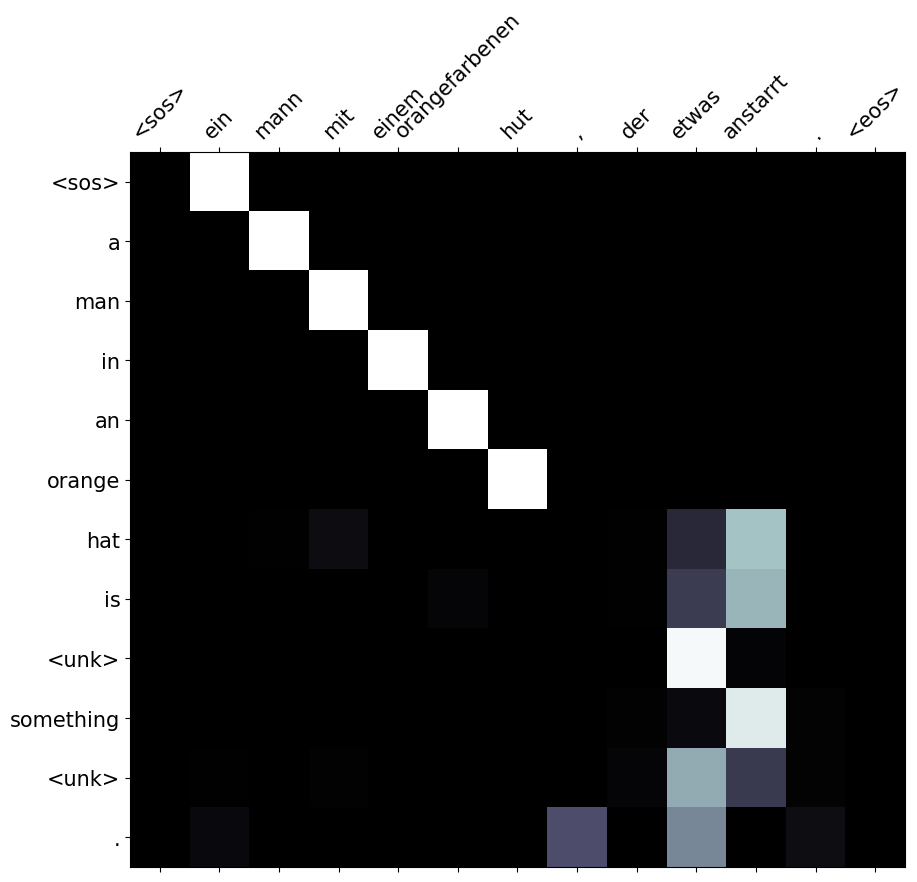

In [60]:
display_attention(sentence, translation, attention)

通过将任何字符串传递给 `translate_sentence` 来使用它来翻译任意句子。

In [61]:
sentence = "Ein Mann sieht sich einen Film an."
translation, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)
translation

['<sos>',
 'a',
 'man',
 'is',
 'looking',
 'at',
 'a',
 'movie',
 'machine',
 '.',
 '<eos>']

## BLEU

以前我们只关心模型的损失/困惑度。然而，有一些专门用于测量翻译质量的指标 - 最流行的是 *BLEU*。不详细介绍，BLEU 从 n-gram 的角度考察了预测目标序列与实际目标序列的重叠程度。它会给我们每个序列一个介于 0 和 1 之间的数字，其中 1 表示完全重叠，即完美翻译，尽管通常显示在 0 和 100 之间。BLEU 最初是为每个源序列有多个候选翻译设计的，但在这个数据集中，每个源序列只有一个候选翻译。

我们从`evaluate`库中加载BLEU指标： 它用来计算数据集上的 BLEU 分数。该函数为每个源语句创建了实际翻译和预测翻译的语料库，然后计算 BLEU 分数。


In [64]:
bleu = evaluate_hf.load("bleu")

循环遍历我们的 `test_data`，得到模型对每个测试句子的翻译。

In [65]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token, 
    )[0] for example in tqdm(test_data)
]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [66]:
predictions = [
    " ".join(translation[1:-1]) for translation in translations
]

references = [
    [example["en"]] for example in test_data
]

def get_tokenizer_fn(nlp, lower):
    
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens
        
    return tokenizer_fn

In [67]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)
results = bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)
results

{'bleu': 0.18870662757692383,
 'precisions': [0.3744122965641953,
  0.2359848484848485,
  0.14905566600397616,
  0.09628661087866108],
 'brevity_penalty': 1.0,
 'length_ratio': 1.6939807014856794,
 'translation_length': 22120,
 'reference_length': 13058}